# Analyzing data science articles

This notebook recreate the study present [here](https://medium.com/the-mission/this-new-data-will-make-you-rethink-how-you-write-headlines-751358f6639a) focusing in data science articles. 

The data for this notebook can be found [here](https://www.kaggle.com/viniciuslambert/medium-data-science-articles-dataset).


## TODO


- [X] What words combinations get the most Engagement?
- [X] What words combinations get less engagement?
- [X] What words combinations get more engagement in the start of headline?
- [X] What words combinations get more engagement in the end of headline?
- [ ] What is the 'magical' number that get most engament?
- [ ] What is the better day to post?

In [1]:
import numpy as np
import pandas as pd
import unicodedata
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_colwidth', None)

df = pd.read_csv('medium-data-science-articles-2020.csv')


df.shape
#df.head()

(108021, 10)

# Preparing data

## Find url duplicateds values and drop it

In [2]:
print(f' We have {df.url.duplicated().sum()} duplicated values in url colum')
#df[df.url.duplicated(keep=False)]

 We have 50 duplicated values in url colum


In [3]:
# I analysed the values and conclude that the correct duplicated values 
#is aways the first! So let's keep it.

df = df.drop_duplicates(subset=['url'], keep='first')
print(f' We have {df.url.duplicated().sum()} duplicated values in url column')
df.shape

 We have 0 duplicated values in url column


(107971, 10)

## Modeling Data

### Data understanding

In [4]:
#df.title[:30]

### Cleaning the data

As you can see, it has some confusing character, so we need to normalize the data.

In [5]:
def normalize_title(title):
    title = unicodedata.normalize("NFKD", title) # normalize data
    title = re.sub('<[^>]+>', '', title) # remove anything beteween <> (html noise)
    title = re.sub(" \d+", r" X", title) # replace numbers by X 
    return title 
    
df.title = df.title.apply(normalize_title)
df.title[:10]

0                                              Making Python Programs Blazingly Fast
1                                                        How to be fancy with Python
2                   How exactly do you find insights from qualitative user research?
3    From scratch to search: playing with your data (Elasticsearch Ingest Pipelines)
4                         The Waiting Paradox: An Intro to Probability Distributions
5                                 Sentiment Analysis of Movie Reviews in NLTK Python
6                               How to Write Scripts That Check Data Quality For You
7                      Gradient Based Optimizations: Jacobians, Jababians & Hessians
8                     [Time Series Forecast] Anomaly detection with Facebook Prophet
9                                                         Decision Trees for Dummies
Name: title, dtype: object

## Get data insights
### Extracting word combinations data from headline

In [6]:
dict_word_combinations = {}

for title, claps, responses in zip(df.title, df.claps, df.responses):
    splited_title = title.split(' ')
    if len(splited_title) > 2:
        for i in range((len(splited_title) - 2)):
            word_combination = f'{splited_title[i]} {splited_title[i+1]} {splited_title[i+2]}' 
            if word_combination in dict_word_combinations.keys():
                dict_word_combinations[word_combination]['frequency'] += 1
                dict_word_combinations[word_combination]['total_claps'] += claps
                dict_word_combinations[word_combination]['total_responses'] += responses
            else:
                dict_word_combinations[word_combination] = {'word_combination': word_combination,
                                                            'frequency' : 1, 
                                                            'total_claps': claps,
                                                            'total_responses': responses,
                                                            'first_words': 0,
                                                            'first_words_total_claps' : 0,
                                                            'last_words': 0,
                                                            'last_words_total_claps' : 0,
                                                           }
                                                            
            if i == 0:
                dict_word_combinations[word_combination]['first_words'] += 1
                dict_word_combinations[word_combination]['first_words_total_claps'] += claps
            if i == len(splited_title) - 3:
                dict_word_combinations[word_combination]['last_words'] += 1
                dict_word_combinations[word_combination]['last_words_total_claps'] += claps

In [11]:
df_word_combination = pd.DataFrame([dict_word_combinations[x] for x in dict_word_combinations.keys()])
df_word_combination

,word_combination,frequency,total_claps,total_responses,first_words,first_words_total_claps,last_words,last_words_total_claps
0,Making Python Programs,1,3300.0,3,1,3300.0,0,0.0
1,Python Programs Blazingly,1,3300.0,3,0,0.0,0,0.0
2,Programs Blazingly Fast,1,3300.0,3,0,0.0,1,3300.0
3,How to be,33,5831.0,27,26,5414.0,0,0.0
4,to be fancy,2,2673.0,13,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...
483987,Balanced Scorecard Dashboard,1,0.0,0,1,0.0,0,0.0
483988,Scorecard Dashboard —,1,0.0,0,0,0.0,0,0.0
483989,Dashboard — Adding,1,0.0,0,0,0.0,0,0.0
483990,— Adding Value,1,0.0,0,0,0.0,0,0.0


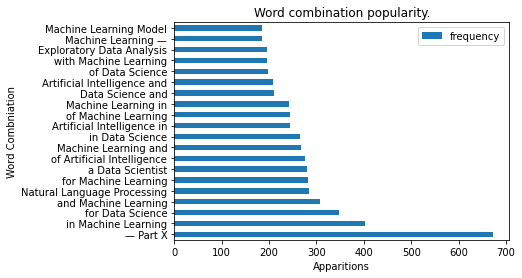

In [39]:
df_word_combination.sort_values('frequency',ascending=False)[:20].plot.barh(x='word_combination', y='frequency')
plt.title('Word combination popularity.')
plt.xlabel('Apparitions')
plt.ylabel('Word Combniation')
plt.show()

### What headline set of words atract more claps?

In [34]:
#list_word_combination

In [46]:
#Extract mena values for claps and trashold for freqency to remove outliers

X = 50
df_word_combination['claps_mean'] = df_word_combination.apply(lambda row: 
                                                              row.total_claps / row.frequency 
                                                              if row.frequency >= X 
                                                              else None , axis=1)

Y = 25
df_word_combination['last_words_claps_mean'] = df_word_combination.apply(lambda row: 
                                                              row.last_words_total_claps / row.last_words 
                                                              if row.last_words >= Y
                                                              else None , axis=1)

Z = 25
df_word_combination['first_words_claps_mean'] = df_word_combination.apply(lambda row: 
                                                              row.first_words_total_claps / row.first_words 
                                                              if row.first_words >= Z
                                                              else None , axis=1)

df_word_combination.head()

,word_combination,frequency,total_claps,total_responses,first_words,first_words_total_claps,last_words,last_words_total_claps,claps_mean,last_words_claps_mean,first_words_claps_mean
0,Making Python Programs,1,3300.0,3,1,3300.0,0,0.0,NaN,NaN,NaN
1,Python Programs Blazingly,1,3300.0,3,0,0.0,0,0.0,NaN,NaN,NaN
2,Programs Blazingly Fast,1,3300.0,3,0,0.0,1,3300.0,NaN,NaN,NaN
3,How to be,33,5831.0,27,26,5414.0,0,0.0,NaN,NaN,208.230769
4,to be fancy,2,2673.0,13,0,0.0,0,0.0,NaN,NaN,NaN


In [47]:
print(f' There are {df_word_combination.claps_mean.notna().sum()} set of words that appear more than {X} times')
print(f' There are {df_word_combination.last_words_claps_mean.notna().sum()} set of words as last words that appear more than {Y} times')
print(f' There are {df_word_combination.first_words_claps_mean.notna().sum()} set of words as first words that appear more than {Z} times')

 There are 183 set of words that appear more than 50 times
 There are 72 set of words as last words that appear more than 25 times
 There are 129 set of words as first words that appear more than 25 times


In [37]:
list_word_combination_trashholded_by_frequency_sorted_by_clap_means = sorted(list_word_combination_trashholded_by_frequency,
                                                                             key=lambda x: x['claps_mean'], reverse=True)

list_word_combination_trashholded_by_last_words_sorted_by_clap_means = sorted(list_word_combination_trashholded_by_last_words,
                                                                             key=lambda x: x['last_words_claps_mean'], reverse=True)

list_word_combination_trashholded_by_first_words_sorted_by_clap_means = sorted(list_word_combination_trashholded_by_first_words,
                                                                             key=lambda x: x['first_words_claps_mean'], reverse=True)

df_word_combination_trashholded_by_frequency_sorted_by_clap_means = pd.DataFrame(list_word_combination_trashholded_by_frequency_sorted_by_clap_means)
df_word_combination_trashholded_by_last_words_sorted_by_clap_means = pd.DataFrame(list_word_combination_trashholded_by_last_words_sorted_by_clap_means)
df_word_combination_trashholded_by_first_sorted_by_clap_means = pd.DataFrame(list_word_combination_trashholded_by_first_words_sorted_by_clap_means)




df_word_combination_trashholded_by_last_words_sorted_by_clap_means

NameError: name 'list_word_combination_trashholded_by_frequency' is not defined

## Analysing Best words combinations

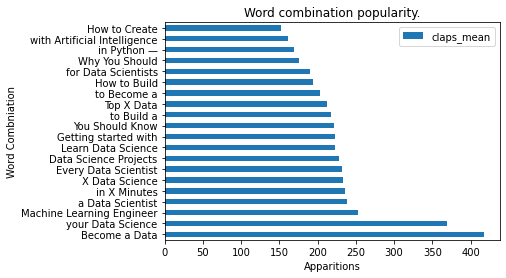

In [40]:
df_word_combination.sort_values('claps_mean',ascending=False)[:20].plot.barh(x='word_combination', y='claps_mean')
plt.title('Most attractive last words combinations')
plt.xlabel('Claps Means')
plt.ylabel('Word combinations')
plt.show()

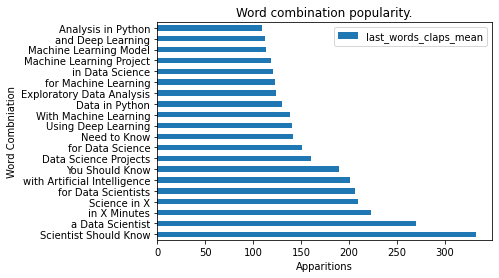

In [48]:
df_word_combination.sort_values('last_words_claps_mean',ascending=False)[:20].plot.barh(x='word_combination', y='last_words_claps_mean')
plt.title('Word combination popularity.')
plt.xlabel('Apparitions')
plt.ylabel('Word Combniation')
plt.show()

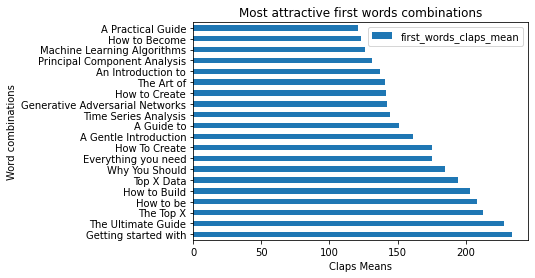

In [49]:
df_word_combination.sort_values('first_words_claps_mean',ascending=False)[:20].plot.barh(x='word_combination', y='first_words_claps_mean')
plt.title('Most attractive first words combinations')
plt.xlabel('Claps Means')
plt.ylabel('Word combinations')
plt.show()

## Analysing Worses words combinations

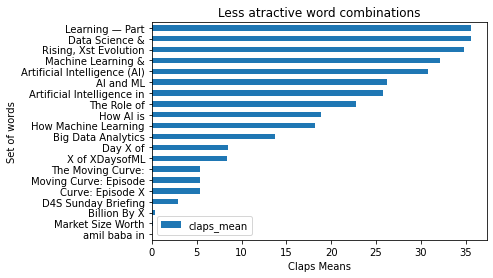

In [52]:
df_word_combination.sort_values('claps_mean',ascending=True)[:20].plot.barh(x='word_combination', y='claps_mean')
plt.title('Less atractive word combinations')
plt.xlabel('Claps Means')
plt.ylabel('Set of words')
plt.show()

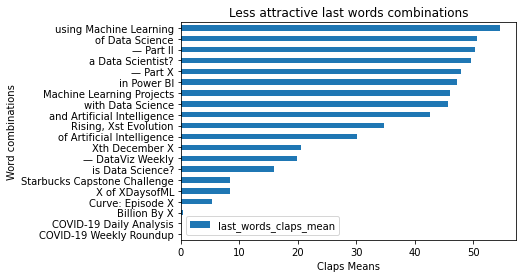

In [53]:
df_word_combination.sort_values('last_words_claps_mean',ascending=True)[:20].plot.barh(x='word_combination', y='last_words_claps_mean')
plt.title('Less attractive last words combinations')
plt.xlabel('Claps Means')
plt.ylabel('Word combinations')
plt.show()

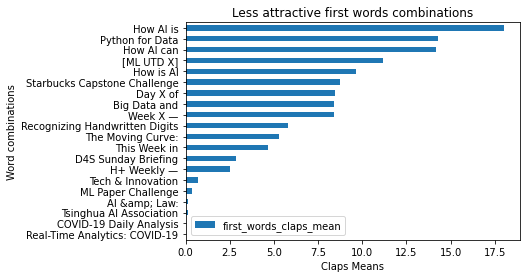

In [55]:
df_word_combination.sort_values('first_words_claps_mean',ascending=True)[:20].plot.barh(x='word_combination', y='first_words_claps_mean')
plt.title('Less attractive first words combinations')
plt.xlabel('Claps Means')
plt.ylabel('Word combinations')
plt.show()